In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch.nn
from tqdm.auto import tqdm
import numpy as np
import os
import pandas as pd
from omegaconf import OmegaConf
from hydra.utils import instantiate
import sys
from datetime import datetime

sys.path.append("..")
import os

/home/vadim/miniconda3/envs/hydra-torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Prepare observations

In [22]:
from src.datamodule.Lorenz96 import L96DataLoader
import hashlib

In [23]:
base_dir = "/home/vadim/Dev/hidden-process-learning"
data_dir = os.path.join(base_dir, "data")
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

# One level model

In [24]:
dt: float = 0.01
f: float = 8
k: int = 40
n_steps: int = 500
spin_up_steps: int = 500
noise_sigma: float = 1.0
part_missing: float = 0.25
seed = 112

In [25]:
pl.seed_everything(seed)

Global seed set to 112


112

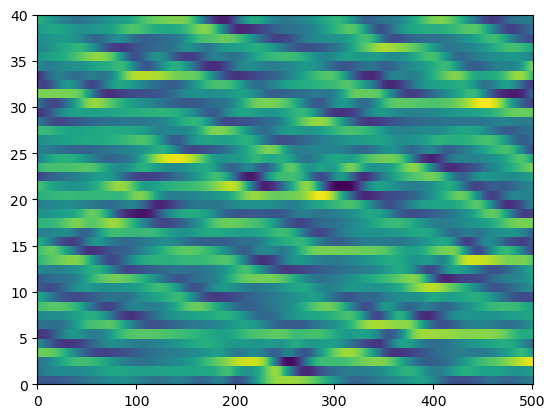

In [32]:
x_true = L96DataLoader.simulate_lorenz96_one_level(dt, k, f, n_steps, spin_up_steps)
plt.pcolor(x_true)

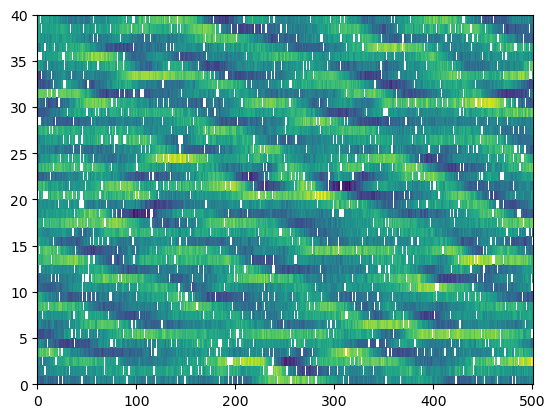

In [33]:
x_obs = L96DataLoader.corrupt_simulation(x_true.clone(), noise_sigma, part_missing)
x_obs_preview = x_obs.clone()
# x_obs_preview[x_obs_preview == 0] = np.nan
plt.pcolor(x_obs_preview)

In [34]:
data = {
    "x_true": x_true,
    "x_obs": x_obs,
    "params": {
        "f": torch.tensor([f]),
    },
    "meta": {
        "dt": dt,
        "f": f,
        "k": k,
        "n_steps": n_steps,
        "spin_up_steps": spin_up_steps,
        "noise_sigma": noise_sigma,
        "part_missing": part_missing,
        "seed": seed,
    },
}

In [35]:
s = str(sorted(data['meta'].items()))
hash_int = int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
np.save(
    os.path.join(data_dir, f"l96-1-{hash_int}.npy"),
    data,
    allow_pickle=True,
)

In [36]:
hash_int

65402354

# Two levels model

In [192]:
dt: float = 0.01
f: float = 10
b: float = 10
c: float = 1
h: float = 10
k: int = 36
j: int = 10
n_steps: int = 500
spin_up_steps: int = 500
noise_sigma: float = 0.5
part_missing: float = 0.9
seed = 112

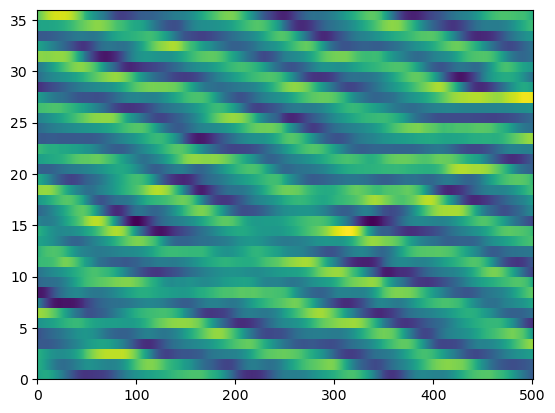

In [193]:
x_true = L96DataLoader.simulate_lorenz96_two_levels(dt, k, j, b, c, f, h, n_steps, spin_up_steps)
plt.pcolor(x_true)

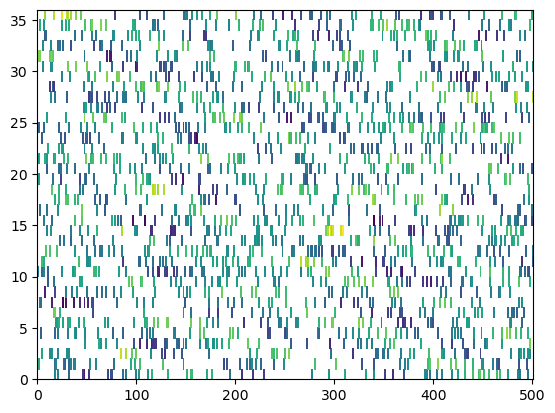

In [194]:
x_obs = L96DataLoader.corrupt_simulation(x_true, noise_sigma, part_missing)
x_obs_preview = x_obs.clone()
x_obs_preview[x_obs_preview == 0] = np.nan
plt.pcolor(x_obs_preview)

In [195]:
data = {
    "x_true": x_true,
    "x_obs": x_obs,
    "params": {
        "f": torch.tensor([f]),
        "b": torch.tensor([b]),
        "c": torch.tensor([c]),
        "h": torch.tensor([h]),
    },
    "meta": {
        "dt": dt,
        "f": f,
        "b": b,
        "c": c,
        "h": h,
        "k": k,
        "j": j,
        "n_steps": n_steps,
        "spin_up_steps": spin_up_steps,
        "noise_sigma": noise_sigma,
        "part_missing": part_missing,
        "seed": seed,
    },
}

In [196]:
s = str(sorted(data['meta'].items()))
hash_int = int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
np.save(
    os.path.join(data_dir, f"l96-2-{hash_int}.npy"),
    data,
    allow_pickle=True,
)

# Run Data Assimilation

In [37]:
from src.datamodule import Dataset4DVar
from torch.utils.data import DataLoader

In [77]:
# loading experiment config file
base_path = "/home/vadim/Dev/hidden-process-learning/outputs/outputs/2022-12-08/04-58-04/"
config_path = os.path.join(base_path, ".hydra/config.yaml")
cfg = OmegaConf.load(config_path)

In [78]:
# instantiating models
model = instantiate(cfg.model)
assimilator = instantiate(cfg.assimilator)
lit_model = instantiate(cfg.lightning_module, model=model, assimilation_model=assimilator, optimizer=cfg.optimizer)

In [79]:
# loading state dict
state_dict_path = os.path.join(base_path, "logs/checkpoints/epoch=03.ckpt")
state_dict = torch.load(state_dict_path)
lit_model = lit_model.load_from_checkpoint(state_dict_path, model=model, assimilation_model=assimilator, optimizer=cfg.optimizer)

## Run on training and validation data

In [80]:
base_dir = "/home/vadim/Dev/hidden-process-learning"
data_file = "data/l96-1-65402354.npy"
data = np.load(os.path.join(base_dir, data_file), allow_pickle=True).item()
data["meta"]

{'dt': 0.01,
 'f': 8,
 'k': 40,
 'n_steps': 500,
 'spin_up_steps': 500,
 'noise_sigma': 1.0,
 'part_missing': 0.25,
 'seed': 112}

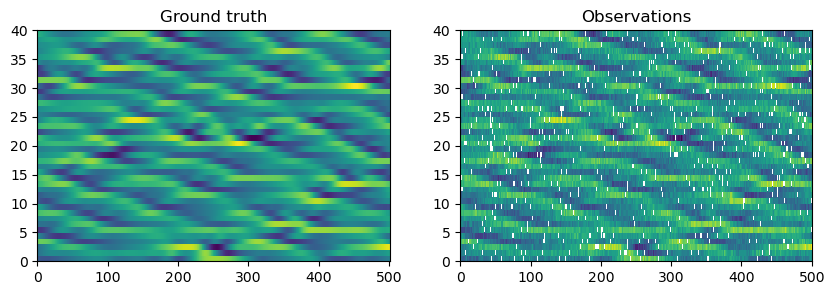

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].set_title("Ground truth")
axs[0].pcolor(data["x_true"])

axs[1].set_title("Observations")
x_obs_preview = data["x_obs"].clone()
x_obs_preview[x_obs_preview == 0] = np.nan
axs[1].pcolor(x_obs_preview)

In [82]:
params = data["params"].copy()
x_obs = data["x_obs"].clone()
dataset = Dataset4DVar(x_obs, params, cfg.datamodule.chunk_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

/home/vadim/Dev/hidden-process-learning/notebooks/../src/datamodule/__init__.py:18: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817693763/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1581.)
  mask[masked_indexes] = 0
/home/vadim/Dev/hidden-process-learning/notebooks/../src/datamodule/__init__.py:19: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664817693763/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1581.)
  data[masked_indexes] = 0


100%|██████████| 477/477 [00:00<00:00, 487.12it/s]


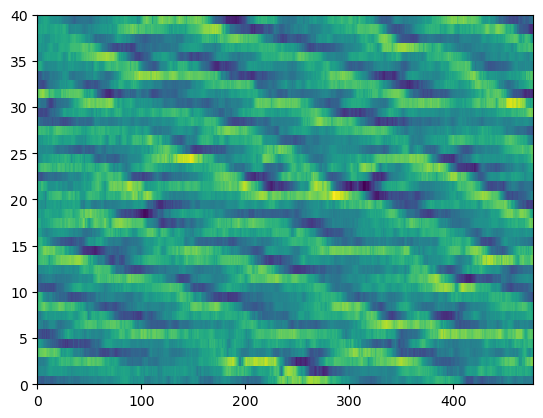

In [83]:
reconstruction = []
for batch in tqdm(dataloader):
    ff_input, _, params = batch
    ff_input = ff_input.squeeze()[0].unsqueeze(0)
    ic = assimilator.forward(ff_input)
    reconstruction.append(ic.squeeze())
reconstruction = torch.stack(reconstruction, dim=-1).squeeze().detach().numpy()
plt.pcolor(reconstruction)

In [84]:
ground_truth = data["x_true"][..., :reconstruction.shape[-1]]
observations = x_obs[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations[observations == 0] = np.nan

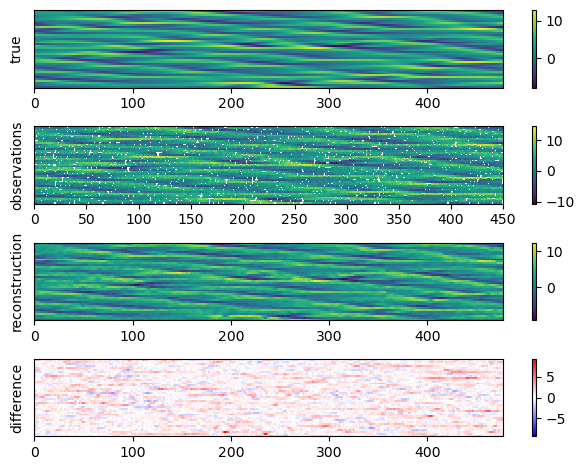

In [85]:
fig, axes = plt.subplots(4, 1, facecolor="w")

axes[0].set_ylabel("true")
img0 = axes[0].pcolor(ground_truth)
plt.colorbar(img0, ax=axes[0])

axes[1].set_ylabel("observations")
img1 = axes[1].pcolor(observations)
plt.colorbar(img1, ax=axes[1])

axes[2].set_ylabel("reconstruction")
img2 = axes[2].pcolor(reconstruction)
plt.colorbar(img2, ax=axes[2])

axes[3].set_ylabel("difference")
diff = ground_truth - reconstruction
vlim = abs(diff).max()
img3 = axes[3].pcolor(diff, cmap="bwr", vmin=-vlim, vmax=vlim)
plt.colorbar(img3, ax=axes[3])

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()
plt.savefig("chunk_size_25_window_50.png", dpi=300)

In [18]:
ground_truth.shape

torch.Size([40, 496])

## Run on test data

In [57]:
meta = data["meta"].copy()
meta["spin_up_steps"] += meta["n_steps"]
meta["n_steps"] = 300

seed = meta.pop("seed")
noise_sigma = meta.pop("noise_sigma")
part_missing = meta.pop("part_missing")

In [58]:
params = data["params"].copy()
pl.seed_everything(seed)
if "j" in params.keys():
    x_true = L96DataLoader.simulate_lorenz96_two_levels(**meta)
else:
    x_true = L96DataLoader.simulate_lorenz96_one_level(**meta)
x_obs = L96DataLoader.corrupt_simulation(x_true, noise_sigma, part_missing)

Global seed set to 112


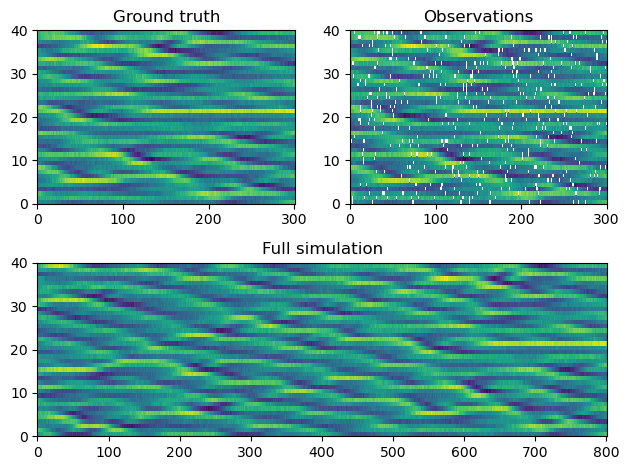

In [59]:
mosaic ="""
AB
CC
"""
fig, daxes = plt.subplot_mosaic(mosaic)
daxes["A"].set_title("Ground truth")
daxes["A"].pcolor(x_true)

daxes["B"].set_title("Observations")
x_obs_preview = x_obs.clone()
x_obs_preview[x_obs_preview == 0] = np.nan
daxes["B"].pcolor(x_obs_preview)

daxes["C"].set_title("Full simulation")
daxes["C"].pcolor(torch.concat([data["x_true"], x_true], dim=-1))
plt.tight_layout()

In [60]:
dataset = AssimilationDataset(x_obs.unsqueeze(0), params, cfg.datamodule.chunk_size)
dataloader = DataLoader(dataset, batch_size=1)

100%|██████████| 148/148 [00:00<00:00, 209.25it/s]


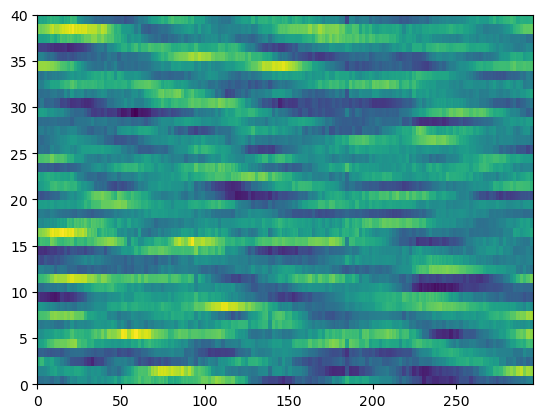

In [61]:
reconstruction = []
for batch in tqdm(dataloader):
    neighbors, _, _, params = batch
    ic_neighbors = neighbors.squeeze()[0]
    ic = assimilator.forward(ic_neighbors)
    rollout = [ic.unsqueeze(0)]
    for i in range(cfg.datamodule.chunk_size - 1):
        x = model.forward(rollout[-1], **params)
        rollout.append(x)
    reconstruction += rollout
reconstruction = torch.stack(reconstruction).squeeze().detach().numpy().T
plt.pcolor(reconstruction)

In [62]:
ground_truth = x_true[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations = x_obs[..., cfg.datamodule.chunk_size:-cfg.datamodule.chunk_size-1]
observations[observations == 0] = np.nan

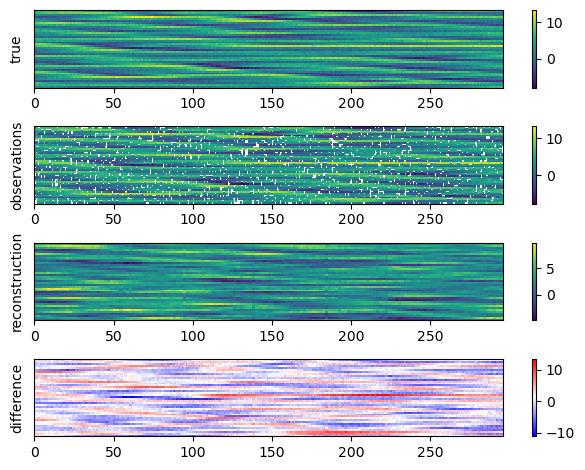

In [63]:
fig, axes = plt.subplots(4, 1, facecolor="w")

axes[0].set_ylabel("true")
img0 = axes[0].pcolor(ground_truth)
plt.colorbar(img0, ax=axes[0])
axes[1].set_ylabel("observations")
img1 = axes[1].pcolor(observations)
plt.colorbar(img1, ax=axes[1])

axes[2].set_ylabel("reconstruction")
img2 = axes[2].pcolor(reconstruction)
plt.colorbar(img2, ax=axes[2])

axes[3].set_ylabel("difference")
img3 = axes[3].pcolor(ground_truth-reconstruction, cmap="bwr")
plt.colorbar(img3, ax=axes[3])

for ax in axes:
    ax.set_yticks([])

plt.tight_layout()

In [40]:
import torch
import torch.nn as nn
import torchvision

In [39]:
class Conv1dBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [37]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3)

    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [38]:
class Encoder(nn.Module):
    def __init__(self, layers=(2,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Conv2dBlock(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            print(x.shape)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [50]:
class Decoder(nn.Module):
    def __init__(self, layers=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.layers = layers
        self.upconvs = nn.ModuleList([nn.ConvTranspose1d(layers[i], layers[i+1], 2, 2) for i in range(len(layers)-1)])
        self.dec_blocks = nn.ModuleList([Conv1dBlock(layers[i], layers[i+1]) for i in range(len(layers)-1)])

    def forward(self, x, encoder_features):
        for i in range(len(self.layers)-1):
            x = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x = torch.cat([x, enc_ftrs], dim=1)
            x = self.dec_blocks[i](x)
        return x

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [51]:
# generate fake input
x = torch.randn(torch.Size((1, 1, 40, 25)))
m = torch.full_like(x, 1)
input = torch.concat((x, m), dim=1)

In [54]:
encoder = Encoder(layers=(2, 64, 128))
output = encoder.forward(input)

torch.Size([1, 64, 36, 21])
torch.Size([1, 128, 14, 6])


In [53]:
decoder = Decoder(layers=(128, 64))
decoder.forward(output[::-1][0], output[::-1][1:])

RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv_transpose1d, but got input of size: [1, 128, 14, 6]